# House Prices: Advanced Regression Techniques
In this kaggle comepetition, one has to predict the final price of each home given its features. In this comepetition, most of the datatype of features are `string` instead of `float`.  <br/>
More detail can be found [Here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
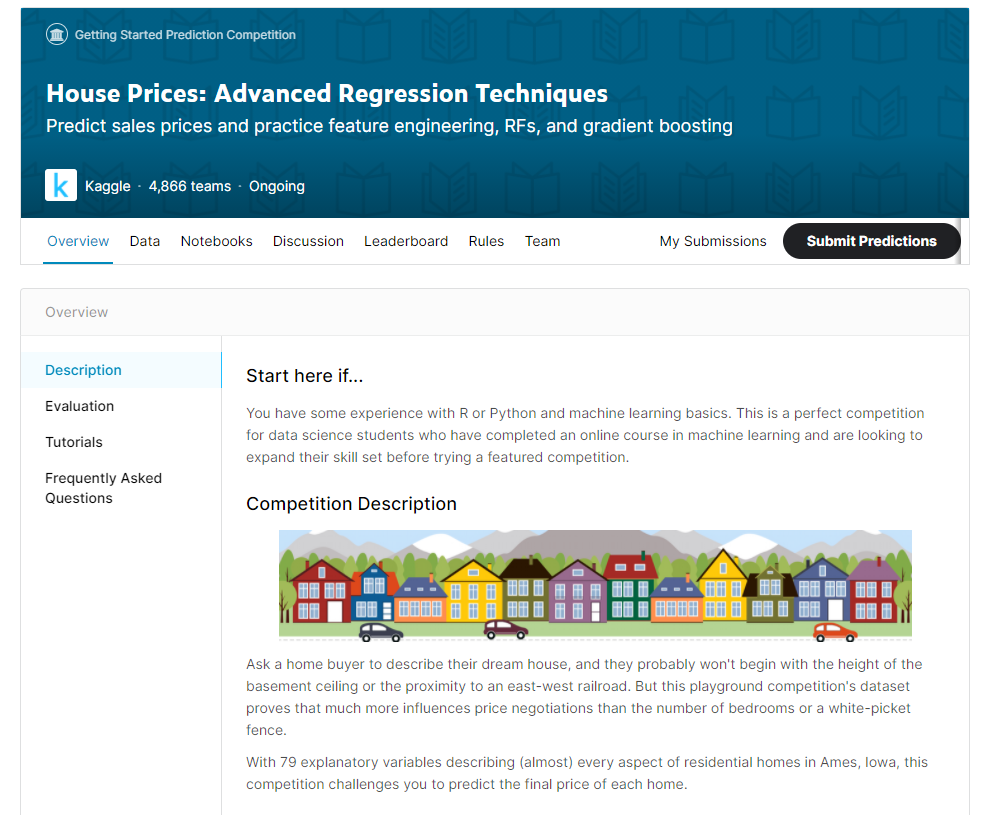

### <center>$1^{st}.$ Download data form kaggle </center>

In [1]:
import sys, os,glob
import zipfile

def unzip():
    if os.path.isfile('train.csv') and os.path.isfile('test.csv'):  # in general, train / test on kaggle has the same name
        print('files have been unzipped.')
    else:
        unzip_list = glob.glob('*zip')
        for zipFile in unzip_list:
            with zipfile.ZipFile(zipFile,"r") as zip_ref:
                zip_ref.extractall('./')
unzip()

files have been unzipped.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

trainDF = pd.read_csv('train.csv')
testDF  = pd.read_csv('test.csv')
# print(trainDF.info())
# print(testDF.info())
# print(trainDF.dtypes)
# print(set(trainDF.dtypes))
# print(set(trainDF.columns)- set(testDF.columns))
print(trainDF.shape)
print(testDF.shape)
#Save the 'Id' column
train_ID = trainDF['Id']
test_ID = testDF['Id']
train_sample_nums = trainDF.shape[0]
print(train_sample_nums)
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
trainDF.drop("Id", axis = 1, inplace = True)
testDF.drop("Id", axis = 1, inplace = True)

(1460, 81)
(1459, 80)
1460


### some basic information about saleprice (final predition target)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
2.2773853960407466
Skewness = 1.8828757597682129
Kurtosis = 6.536281860064529
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  Y

C:\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


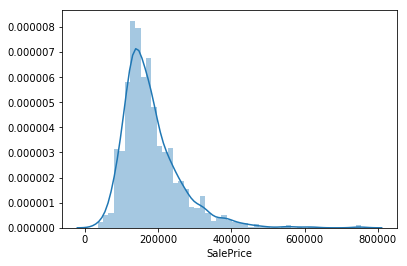

In [10]:
print(trainDF.SalePrice.describe())
sns.distplot(trainDF.SalePrice)
print(trainDF.SalePrice.mean() / trainDF.SalePrice.std() )
print('Skewness = {}'.format(trainDF.SalePrice.skew()))
print('Kurtosis = {}'.format(trainDF.SalePrice.kurt()))
y_train = trainDF.SalePrice.values
trainDF.drop("SalePrice",axis=1,inplace=True)
all_data = pd.concat((trainDF, testDF)).reset_index(drop=True)
print(all_data.describe())

In [12]:
print(all_data.head())

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
3         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   
4         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         N

### <center>$2^{nd}.$ preprocess  </center>

Here we try to saperate the data into 2 parts. One  composed of `nums`, and the other one are `strings`. <br>
For `nums` data, we want to perform some data cleaning techniques such as :
* reducing the dependent features
* reducing the outlier
* filling in NA columns
* standarlizing data (optional)

(2919, 36)
(2919, 43)
(2919, 79)
   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
0          2003       196.0       706.0         0.0  ...       548.0   
1          1976         0.0       978.0         0.0  ...       460.0   
2          2002       162.0       486.0         0.0  ...       608.0   
3          1970         0.0       216.0         0.0  ...       642.0   
4          2000       350.0       655.0         0.0  ...       836.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  

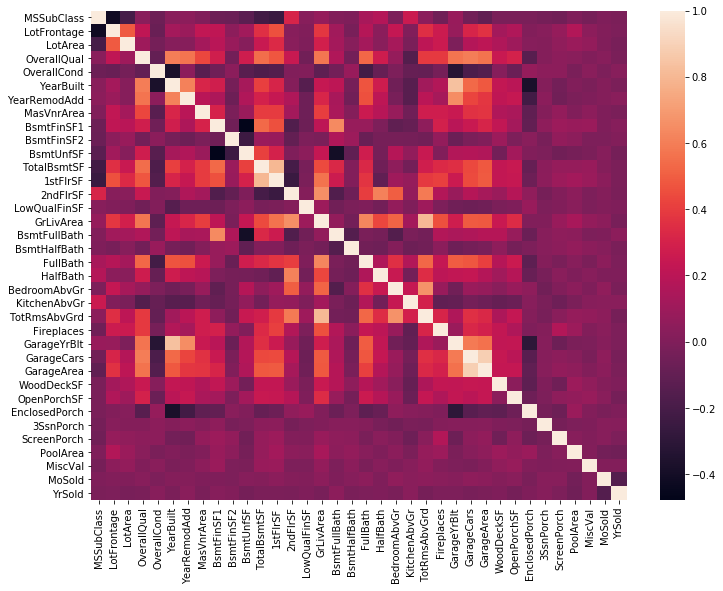

In [21]:
# saparate data 
all_data_nums = all_data[[c for c in all_data.columns if all_data.dtypes[c] in {np.dtype("float64"),np.dtype("int64")} ]]
print(all_data_nums.shape)  # 36 features
all_data_strings = all_data[[c for c in all_data.columns if all_data.dtypes[c] in {np.dtype("object")}]]
print(all_data_strings.shape)  # 43 features
print(all_data.shape)  # 79 features = 36 + 43
print(all_data_nums.head())
print(all_data_strings.head())

# to see the dependent variables, we can plot correlation matrix to see the problem roughly
corrmat = all_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=False);

From correlation matrix, we find there are two groups of features whcih are dependent on each others. 
    - TotalBsmtSF , 1stFlrSF and  2ndFltSF
    - GarageCars , GarageYrBlt and GarageArea
Once we find those dependent variable, we can drop and leave one of them. However, it is not a systematic way to do this risky analysis. I found [this](https://kknews.cc/zh-tw/code/q9ke34g.html) and [this](https://ccjou.wordpress.com/2010/07/01/%E6%A2%9D%E4%BB%B6%E6%95%B8/) may be useful. <br>
In general , we will need to exam collinear problem. And there are several factors and solutions to deal with that.

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
NonNans =  all_data_nums.dropna()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(NonNans[~pd.isnull(NonNans)].values, i) for i in range(NonNans.shape[1])]
vif["features"] = all_data_nums.columns
print(vif)

C:\Miniconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


      VIF Factor       features
0   4.710953e+00     MSSubClass
1   1.886222e+01    LotFrontage
2   4.731467e+00        LotArea
3   6.508332e+01    OverallQual
4   4.693063e+01    OverallCond
5   2.409749e+04      YearBuilt
6   2.285596e+04   YearRemodAdd
7   1.983004e+00     MasVnrArea
8            inf     BsmtFinSF1
9            inf     BsmtFinSF2
10           inf      BsmtUnfSF
11           inf    TotalBsmtSF
12           inf       1stFlrSF
13           inf       2ndFlrSF
14           inf   LowQualFinSF
15           inf      GrLivArea
16  3.602507e+00   BsmtFullBath
17  1.229460e+00   BsmtHalfBath
18  2.703090e+01       FullBath
19  3.443093e+00       HalfBath
20  3.183212e+01   BedroomAbvGr
21  4.605173e+01   KitchenAbvGr
22  7.974720e+01   TotRmsAbvGrd
23  2.846778e+00     Fireplaces
24  2.700468e+04    GarageYrBlt
25  3.973478e+01     GarageCars
26  3.473470e+01     GarageArea
27  1.927576e+00     WoodDeckSF
28  1.923901e+00    OpenPorchSF
29  1.413087e+00  EnclosedPorch
30  1.02

In [50]:
# drop VIF factor is inf
all_data = pd.concat((trainDF, testDF)).reset_index(drop=True)
all_data.drop(["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GrLivArea"], axis = 1, inplace = True)
# all_data['totalFlrSF'] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# all_data.drop(["1stFlrSF","2ndFlrSF"],axis = 1, inplace = True)
all_data_nums = all_data[[c for c in all_data.columns if all_data.dtypes[c] in {np.dtype("float64"),np.dtype("int64")} ]]
NonNans =  all_data_nums.dropna()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(NonNans[~pd.isnull(NonNans)].values, i) for i in range(NonNans.shape[1])]
vif["features"] = all_data_nums.columns
print(vif) # maybe need other ways...

      VIF Factor       features
0       4.703999     MSSubClass
1      18.846266    LotFrontage
2       4.710104        LotArea
3      64.175166    OverallQual
4      46.606364    OverallCond
5   23973.406566      YearBuilt
6   22670.202716   YearRemodAdd
7       1.958941     MasVnrArea
8      26.185448    TotalBsmtSF
9      60.905558       1stFlrSF
10      9.151097       2ndFlrSF
11      1.081022   LowQualFinSF
12      2.204198   BsmtFullBath
13      1.149675   BsmtHalfBath
14     27.013050       FullBath
15      3.426732       HalfBath
16     31.579850   BedroomAbvGr
17     45.979641   KitchenAbvGr
18     79.571628   TotRmsAbvGrd
19      2.826487     Fireplaces
20  26995.250263    GarageYrBlt
21     39.452288     GarageCars
22     34.611506     GarageArea
23      1.912596     WoodDeckSF
24      1.923442    OpenPorchSF
25      1.411205  EnclosedPorch
26      1.026786      3SsnPorch
27      1.179910    ScreenPorch
28      1.120572       PoolArea
29      1.078474        MiscVal
30      

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
2914         160         21.0   1936.0          4.0          7.0       1970   
2915         160         21.0   1894.0          4.0          5.0       1970   
2916          20          NaN  20000.0          5.0          7.0       1960   
2917          85         62.0  10441.0          5.0          5.0       1992   
2918          60         74.0   9627.0          7.0          5.0       1993   

      YearRemodAdd  MasVnrArea  TotalBsmtSF  1stFlrSF  ...  GarageArea  \
2914          1970         0.0        546.0     546.0  ...         0.0   
2915          1970         0.0        546.0     546.0  ...       286.0   
2916          1996         0.0       1224.0    1224.0  ...       576.0   
2917          1992         0.0        912.0     970.0  ...         0.0   
2918          1994        94.0        996.0     996.0  ...       650.0   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
2914    

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


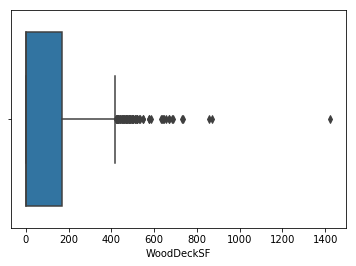

In [52]:
# to see the outlier
# (1) use box plot: those dots are outliers / one can use scatter plot to see outlier
all_data_nums = all_data[[c for c in all_data.columns if all_data.dtypes[c] in {np.dtype("float64"),np.dtype("int64")} ]]
sns.boxplot(all_data_nums["WoodDeckSF"])

#(2) use Z score 
# from scipy import stats
# z_values = np.abs(stats.zscore(trainDF_nums) # for old scipy, can not handle NAN inside
def z_value(df):
    return (df-df.mean())/df.std(ddof=0)
z_values_df = all_data_nums.apply(z_value)
z_values = z_values_df.to_numpy()

threshold = 3.5
all_data_nums = all_data_nums.where((np.abs(z_values)< threshold)) # once we get outlier, that's drop it first
# if not satisfied, the values will change to NAN
print(all_data_nums.tail())

### fill these NA values in our nums data 
Here we have some strategy :
 - If too many loss or unknown values inside some columns, we will simply drop it.
 - If there is not so much, we will fill in medium of the original values
 - For strings data, we will fill in the mode of the column

In [58]:
total_counts = all_data.shape[0]
threshold = total_counts // 2 # if half of the data is NAN, then we will not use it.
for col in all_data_nums:
    if all_data_nums[col].isnull().sum() >= threshold:
        print('{} will not be used in our model for too many NAN ({} in total)'.format(
                                                                                col, trainDF_nums[col].isnull().sum()))
        all_data = all_data.drop([col],axis=1)
    else:
        medium = all_data_nums[col].describe()['50%']
        NAs    = all_data_nums[col].isnull().sum()
        all_data[col] = all_data[col].fillna(medium)
        print('{} NAs have been filled in medium ({})'.format(NAs,medium))
        print('check {}: {} of them  remains NA'.format(col,all_data[col].isnull().sum() ) )
    print('-'*47)


0 NAs have been filled in medium (50.0)
check MSSubClass: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (68.0)
check LotFrontage: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (9453.0)
check LotArea: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (6.0)
check OverallQual: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (5.0)
check OverallCond: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (1973.0)
check YearBuilt: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (1993.0)
check YearRemodAdd: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in medium (0.0)
check MasVnrArea: 0 of them  remains NA
--------------------

In [61]:
# string's data part 
for col in all_data_strings:
    if all_data_strings[col].isnull().sum() >= threshold:
        print('{} will not be used in our model for too many NAN ({} in total)'.format(
                                                                                col, all_data_strings[col].isnull().sum()))
        all_data = all_data.drop([col],axis=1)
    else:
        mode = all_data_strings[col].value_counts()[:1].index[0]
        NAs    = all_data_strings[col].isnull().sum()
        all_data[col] = all_data_strings[col].fillna(mode)
        print('{} NAs have been filled in mode ({})'.format(NAs,mode))
        print('check {}: {} of them  remains NA'.format(col,all_data[col].isnull().sum() ) )
    print('-'*47)

4 NAs have been filled in mode (RL)
check MSZoning: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in mode (Pave)
check Street: 0 of them  remains NA
-----------------------------------------------
Alley will not be used in our model for too many NAN (2721 in total)
-----------------------------------------------
0 NAs have been filled in mode (Reg)
check LotShape: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in mode (Lvl)
check LandContour: 0 of them  remains NA
-----------------------------------------------
2 NAs have been filled in mode (AllPub)
check Utilities: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in mode (Inside)
check LotConfig: 0 of them  remains NA
-----------------------------------------------
0 NAs have been filled in mode (Gtl)
check LandSlope: 0 of them  remains NA
-----------------------------------------------
0 NAs have b

In [62]:
# check no NAN remains:
all_data.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorc

### <center>$3^{th}.$ feature extration   </center>
Using our new dataframe, we will see which features are important or not

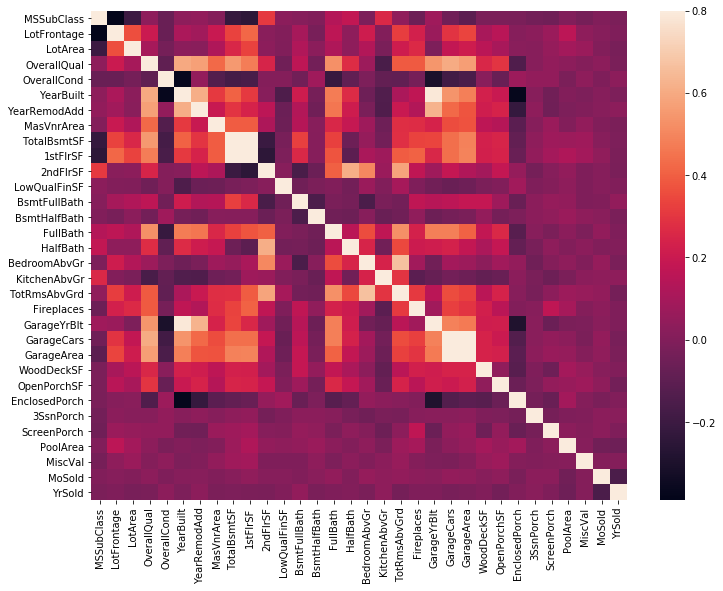

In [63]:
#correlation matrix
corrmat = all_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=False);

C:\Miniconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


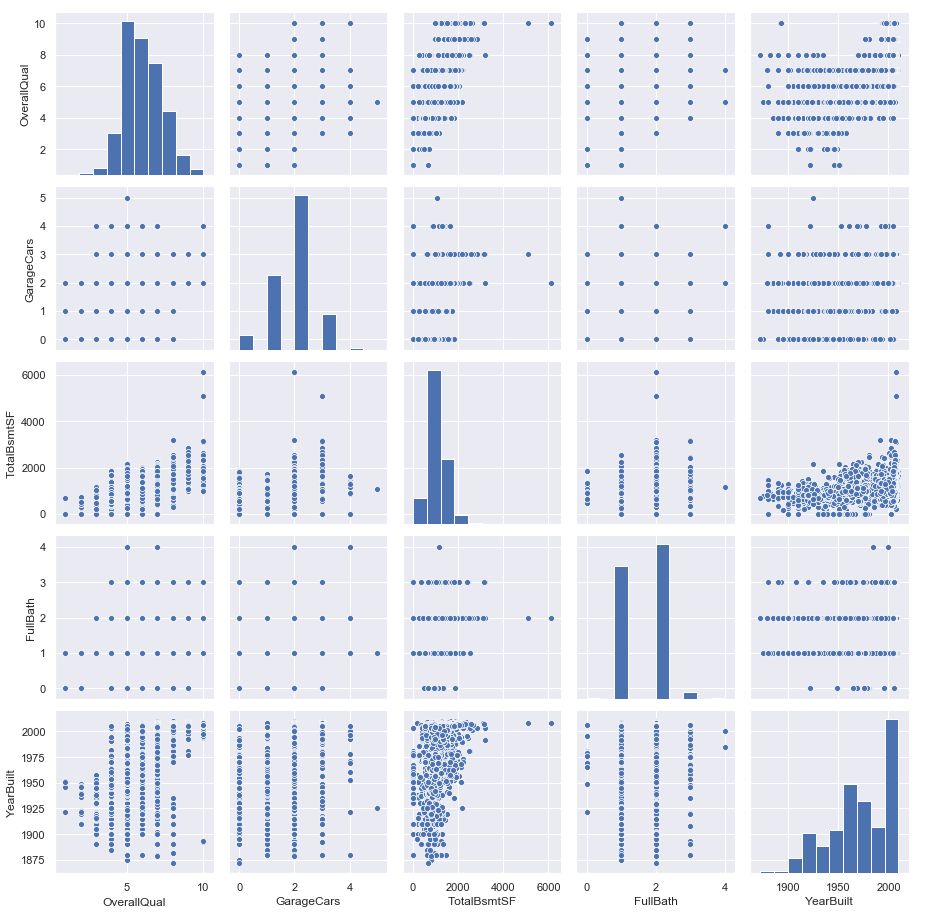

In [67]:
#scatterplot
sns.set()
cols = [ 'OverallQual', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(all_data[cols], size = 2.5)
plt.show();

## Problem remains to be solved:
Here it seems there are some variables whose name look similar, but there is no systematically way to check the dependency of each feature.  <br>
<center> Goal: **try to find a way to reduce features that dependent with others** </center>

In [79]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
all_data_strings = all_data[[c for c in all_data.columns if all_data.dtypes[c] in {np.dtype("object")}]]
# process columns, apply LabelEncoder to categorical features
for c in all_data_strings.columns:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 71)


In [84]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

In [89]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(all_data.values)
    rmse= np.sqrt(-cross_val_score(model, all_data.values[:train_sample_nums,:], y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [90]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 33824.0747 (6992.4462)

Xgboost score: 26275.2745 (3829.4330)



In [92]:
lasso.fit(all_data[:train_sample_nums], y_train)


sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = lasso.predict(all_data.values[train_sample_nums:,])
sub.to_csv('submission.csv',index=False)